In [1]:
! pip install -q kaggle

In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=ebb57dfea908818ea61b7aefadb3ce35b48a7eaf26199407d16c96728dab9729
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"stepantita","key":"78423f6870cd1bf4ffe81c45c9cf05d4"}'}

In [4]:
mkdir -p ~/.kaggle/

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c newsclass01

100% 8.39G/8.39G [03:20<00:00, 34.2MB/s]
100% 8.39G/8.39G [03:20<00:00, 44.9MB/s]


In [8]:
! mkdir data

In [9]:
! unzip newsclass01.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/images/images/d63307bc-c4f6-4de7-9aa0-f2494704be05.png  
  inflating: data/images/images/d6357a78-1e5a-4ef3-ad14-25557f9fcad5.png  
  inflating: data/images/images/d638092e-e380-4e4d-9207-f965cf051241.png  
  inflating: data/images/images/d63dcbbd-b9c2-4732-8b21-8cbb781c36d7.png  
  inflating: data/images/images/d63e6363-fba2-492f-b0ba-de04529c51fc.png  
  inflating: data/images/images/d6448989-36cb-433e-bdcd-520daa67da7a.png  
  inflating: data/images/images/d644ec7f-eb31-4785-ac81-aebcfb89e2a9.png  
  inflating: data/images/images/d645ed80-74af-4360-9054-69fcf4f7905e.png  
  inflating: data/images/images/d6474ccb-6486-4711-a5af-679670d0b098.png  
  inflating: data/images/images/d64bed11-bc18-42f4-8a38-5def46d02834.png  
  inflating: data/images/images/d64d9e21-210c-40fa-8ead-fdd709fdf6eb.png  
  inflating: data/images/images/d64dae03-21dc-400f-b0ee-a5779470bfbe.png  
  inflating: data/images/images/d64f06e9-bba5-4a1

In [10]:
!mv data/test_without_target.csv data/test.csv

In [ ]:
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

import string
import re
import os

In [12]:
data = pd.read_csv('data/train.csv', index_col=0)
data

,title,text,images,source
Id,,,,
1,Міністри Зеленського лишають мільйони пацієнті...,Понад півтора мільйони пацієнтів із тяжкими ді...,NaN,5
2,В АМКУ звертаються щодо незаконної державної д...,За 15 років державна підтримка виробництва ене...,fd92a3dd-1109-49d8-8f5f-eeed72da22ef.png,6
5,У Польщі виявили майже 16 тисяч нових хворих н...,У Польщі виявили 15 698 нових хворих на корона...,f4a284d0-9bb7-4910-8a62-a7bfd0ec29b6.png,2
9,Закриття міжбанку: гривня трохи ослабла,2 жовтня котирування гривні до долара на закри...,NaN,3
10,"У Москві помер український шахіст із бази ""Мир...",У п'ятницю низка російських ЗМІ повідомили про...,"2cbb2339-6dd2-4000-a53c-225ec7aad892.png,d5233...",0
...,...,...,...,...
32366,"""Укрзалізниця"" просить Раду у бюджеті-2021 зак...","""Укрзалізниця"" закликає парламент закласти у д...",NaN,3
32367,Сніг та 20-градусні морози протримаються до ви...,"У вівторок, 16 лютого, в Україні буде без істо...",NaN,2
32368,"Україна хоче оподаткувати Google, Facebook та ...","Гетманцев розповів, як Україна оподатковуватим...",NaN,6


In [13]:
test_data = pd.read_csv('data/test.csv', index_col=0)
test_data

,title,text,images
Id,,,
0,Падіння економіки в Україні не є критичним - ЄБРР,Падіння економічного рівня в Україні не є крит...,NaN
3,Геймерам віддають безкоштовно шутер Rage 2 та ...,Шутер Rage 2 віддають безкоштовно в EGS / фото...,NaN
4,Записки из Луганска: привычка быть виноватыми ...,"""Ты печешь?"" – спрашивает у меня подруга, пере...","4530f95b-a014-424d-aefa-6f69fe82235a.png,2b8bc..."
6,Індекс Dow Jones вперше перевищив 30 тисяч пун...,На тлі новин щодо передачі влади у США та вакц...,NaN
7,Трамп і Меркель обговорили підтримку економічн...,Президент США Дональд Трамп і канцлерка Німечч...,NaN
...,...,...,...
32362,США хочуть закупити ще 100 млн доз вакцини про...,Президент США Джо Байден доручив Міністерству ...,NaN
32363,Вчителька вдарила школярку по голові і відпові...,У Первомайському ліцеї №7 Харківської області ...,0445f65f-358a-4fbb-b8a3-efe5056afba1.png
32364,"""Не розслабляємося"": українців просять святкув...",Президент Володимир Зеленський попросив україн...,"3958be83-2e91-4533-aea5-f3299b8f0f86.png,d6d8f..."


In [14]:
X, y = data.drop(columns=['source']), data['source']

In [15]:
X_train, X_test, y_train = X, test_data, y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
def images_to_tf_format(X, y, dirname):
  base_images_path = './data/images'
  new_images_dir = dirname

  for i, (imgs, source) in enumerate(zip(X['images'], y)):
      if imgs is np.nan:
          continue
      for img_name in imgs.split(','):
          if i % 100 == 0:
              print('Done: {:.2f}'.format((i + 1) / len(X)))
          os.makedirs(base_images_path + new_images_dir + '/' + str(source), 0o777, exist_ok=True)
          os.replace(base_images_path + '/images' + '/' + img_name, base_images_path + new_images_dir + '/' + str(source) + '/' + img_name)

In [ ]:
images_to_tf_format(X_train, y_train, '/train')

Done: 0.01
Done: 0.01
Done: 0.01
Done: 0.01
Done: 0.02
Done: 0.02
Done: 0.02
Done: 0.02
Done: 0.02
Done: 0.02
Done: 0.02
Done: 0.02
Done: 0.02
Done: 0.04
Done: 0.04
Done: 0.04
Done: 0.04
Done: 0.06
Done: 0.06
Done: 0.07
Done: 0.09
Done: 0.10
Done: 0.12
Done: 0.12
Done: 0.14
Done: 0.15
Done: 0.17
Done: 0.17
Done: 0.17
Done: 0.17
Done: 0.17
Done: 0.17
Done: 0.20
Done: 0.20
Done: 0.22
Done: 0.22
Done: 0.22
Done: 0.22
Done: 0.22
Done: 0.22
Done: 0.23
Done: 0.23
Done: 0.24
Done: 0.26
Done: 0.28
Done: 0.28
Done: 0.30
Done: 0.31
Done: 0.32
Done: 0.33
Done: 0.34
Done: 0.34
Done: 0.34
Done: 0.34
Done: 0.34
Done: 0.34
Done: 0.34
Done: 0.35
Done: 0.35
Done: 0.37
Done: 0.43
Done: 0.43
Done: 0.43
Done: 0.45
Done: 0.45
Done: 0.46
Done: 0.46
Done: 0.47
Done: 0.47
Done: 0.47
Done: 0.48
Done: 0.48
Done: 0.48
Done: 0.48
Done: 0.48
Done: 0.48
Done: 0.48
Done: 0.49
Done: 0.50
Done: 0.51
Done: 0.52
Done: 0.53
Done: 0.55
Done: 0.56
Done: 0.57
Done: 0.59
Done: 0.59
Done: 0.60
Done: 0.60
Done: 0.60
Done: 0.60

In [ ]:
images_to_tf_format(X_test, y_test, '/test')

Done: 0.00
Done: 0.02
Done: 0.06
Done: 0.11
Done: 0.17
Done: 0.19
Done: 0.19
Done: 0.22
Done: 0.22
Done: 0.22
Done: 0.22
Done: 0.22
Done: 0.26
Done: 0.26
Done: 0.26
Done: 0.26
Done: 0.26
Done: 0.26
Done: 0.26
Done: 0.26
Done: 0.26
Done: 0.26
Done: 0.26
Done: 0.28
Done: 0.30
Done: 0.32
Done: 0.34
Done: 0.34
Done: 0.34
Done: 0.34
Done: 0.34
Done: 0.36
Done: 0.37
Done: 0.39
Done: 0.41
Done: 0.41
Done: 0.41
Done: 0.41
Done: 0.41
Done: 0.41
Done: 0.41
Done: 0.41
Done: 0.47
Done: 0.49
Done: 0.54
Done: 0.60
Done: 0.64
Done: 0.69
Done: 0.69
Done: 0.73
Done: 0.73
Done: 0.73
Done: 0.73
Done: 0.75
Done: 0.75
Done: 0.75
Done: 0.75
Done: 0.79
Done: 0.79
Done: 0.81
Done: 0.84
Done: 0.84
Done: 0.84
Done: 0.84
Done: 0.84
Done: 0.84
Done: 0.86
Done: 0.86
Done: 0.86
Done: 0.86
Done: 0.86
Done: 0.86
Done: 0.86
Done: 0.86
Done: 0.88
Done: 0.92
Done: 0.92
Done: 0.94
Done: 0.96
Done: 0.96
Done: 0.99
Done: 0.99
Done: 0.99


In [ ]:
# model = EfficientNetB0(weights='imagenet', include_top=True)

In [16]:
data_dir = 'data/images'

In [17]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir + '/train',
  seed=42,
  image_size=IMG_SHAPE,
  batch_size=BATCH_SIZE)

Found 15068 files belonging to 7 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir + '/test',
  seed=42,
  image_size=IMG_SHAPE,
  batch_size=BATCH_SIZE)

FileNotFoundError: ignored

In [18]:
class_names = train_ds.class_names
class_names

NameError: ignored

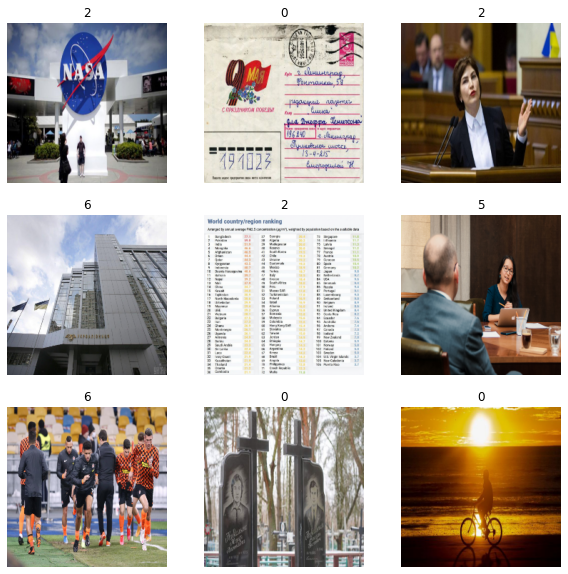

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 299, 299, 3)
(32,)


In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9670966


In [ ]:
epochs = 5

AUTOTUNE = tf.data.AUTOTUNE
AUTOTUNE

-1

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [ ]:
# with strategy.scope():
#   num_classes = len(y_train.unique())

#   inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

#   outputs = EfficientNetB0(weights=None, include_top=True, classes=num_classes)(inputs)

#   model = tf.keras.Model(inputs, outputs)
#   model.compile(
#       optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", f1]
#   )

In [ ]:
num_classes = len(y.unique())

In [ ]:
# inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

extractor = tf.keras.applications.Xception(weights='imagenet', include_top=False)
# extractor.trainable = False

model = tf.keras.models.Sequential([
        extractor,
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
        tf.keras.layers.Flatten(),
    ])

model.compile(
    optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy", f1]
)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
dense (Dense)                (None, None, None, 512)   1049088   
_________________________________________________________________
batch_normalization_4 (Batch (None, None, None, 512)   2048      
_________________________________________________________________
dropout (Dropout)            (None, None, None, 512)   0         
_________________________________________________________________
dense_1 (Dense)              (None, None, None, 128)   65664     
_________________________________________________________________
batch_normalization_5 (Batch (None, None, None, 128)   512       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 128)   0

In [ ]:
hist = model.fit(train_ds, epochs=epochs) # , validation_data=val_ds

Epoch 1/5
168/471 [=========>....................] - ETA: 7:16 - loss: 6.4949 - accuracy: 0.1311 - f1: 0.1123

KeyboardInterrupt: ignored

In [ ]:
del val_ds
del train_ds

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    # plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
extractor = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)

In [ ]:
# feature_model = tf.keras.Model(model.input, model.layers[-2].output)
# feature_model.summary()
feature_model = extractor
feature_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=True).summary()

21839872/21834768 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
____________________

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mv /content/effnet-train-images-features.csv /content/drive/MyDrive/contest/features/effnet-train-images-features.csv

In [ ]:
model.save('/content/drive/MyDrive/contest/models/basic_img_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/contest/models/basic_img_model/assets


In [22]:
model = tf.keras.models.load_model('/content/drive/MyDrive/contest/models/basic_img_model', custom_objects={'f1':f1})
# extractor = tf.keras.models.Model(model.input, model.layers[-3].output)
# extractor
model

In [23]:
num_classes = 7

In [28]:
def predict_images(data, path):
  features = []
  i = 0
  for idx, tc in data.iterrows():
    i += 1
    if i % 100 == 0:
      print(f'----[{i}]----')
    images = tc['images']
    if images is np.nan:
      features.append(np.array([np.nan] * num_classes))
      continue
    best_features = []
    if ',' not in images:
      images = [images, ]
    else:
      images = images.split(',')
    for img_name in images:
      img = cv2.imread(f'./data/images/{path}/{img_name}')
      # print(img.shape, source, img_name)
      img = tf.image.resize(img, IMG_SHAPE) / 255
      # best_features.append(np.apply_over_axes(np.mean, feature_model.predict(img[np.newaxis, :]), [1,]).flatten())
      best_features.append(model.predict(img[np.newaxis, :])[0])
    best_features = np.mean(best_features, axis=0)
    features.append(best_features)
  return pd.DataFrame(features, index=data.index)

In [30]:
res = predict_images(test_data, 'images')
res

----[100]----
----[200]----
----[300]----
----[400]----
----[500]----
----[600]----
----[700]----
----[800]----
----[900]----
----[1000]----
----[1100]----
----[1200]----
----[1300]----
----[1400]----
----[1500]----
----[1600]----
----[1700]----
----[1800]----
----[1900]----
----[2000]----
----[2100]----
----[2200]----
----[2300]----
----[2400]----
----[2500]----
----[2600]----
----[2700]----
----[2800]----
----[2900]----
----[3000]----
----[3100]----
----[3200]----
----[3300]----
----[3400]----
----[3500]----
----[3600]----
----[3700]----
----[3800]----
----[3900]----
----[4000]----
----[4100]----
----[4200]----
----[4300]----
----[4400]----
----[4500]----
----[4600]----
----[4700]----
----[4800]----
----[4900]----
----[5000]----
----[5100]----
----[5200]----
----[5300]----
----[5400]----
----[5500]----
----[5600]----
----[5700]----
----[5800]----
----[5900]----
----[6000]----
----[6100]----
----[6200]----
----[6300]----
----[6400]----
----[6500]----
----[6600]----
----[6700]----
----

,0,1,2,3,4,5,6
Id,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.999996,8.109937e-10,1.844633e-11,2.338347e-08,0.000004,1.699079e-11,1.050983e-09
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
32362,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32363,0.999996,8.505533e-10,1.948186e-11,2.428568e-08,0.000004,1.793689e-11,1.098102e-09
32364,0.999996,8.251294e-10,1.881919e-11,2.372045e-08,0.000004,1.733057e-11,1.067718e-09


In [31]:
res.to_csv('./preds-images-effnet.csv')

In [ ]:
extractor.output.shape

TensorShape([None, 1280])

In [ ]:
# out_features = model.layers[-2].output.shape[-1]
# out_features
out_features = extractor.output.shape[-1]
out_features

1280

In [ ]:
img = cv2.imread('./data/images/test/5/839cf98f-e6ef-4024-8d6f-1641733dd835.png')
img.shape

(512, 512, 3)

In [ ]:
def extract_features(data, path):
  features = []
  i = 0
  for idx, tc in data.iterrows():
    i += 1
    if i % 100 == 0:
      print(f'----[{i}]----')
    images = tc['images']
    if images is np.nan:
      features.append(np.array([np.nan] * out_features))
      continue
    best_proba = [0]
    best_features = []
    if ',' not in images:
      images = [images, ]
    else:
      images = images.split(',')
    for img_name in images:
      source = tc['source']
      img = cv2.imread(f'./data/images/{path}/{source}/{img_name}')
      # print(img.shape, source, img_name)
      img = tf.image.resize(img, IMG_SHAPE) / 255
      # best_features.append(np.apply_over_axes(np.mean, feature_model.predict(img[np.newaxis, :]), [1,]).flatten())
      best_features.append(feature_model.predict(img[np.newaxis, :])[0])
    best_features = np.mean(best_features, axis=0)
    features.append(best_features)
  return pd.DataFrame(features, index=data.index)

In [ ]:
features_train = extract_features(data, 'train')
features_train

----[100]----
----[200]----
----[300]----
----[400]----
----[500]----
----[600]----
----[700]----
----[800]----
----[900]----
----[1000]----
----[1100]----
----[1200]----
----[1300]----
----[1400]----
----[1500]----
----[1600]----
----[1700]----
----[1800]----
----[1900]----
----[2000]----
----[2100]----
----[2200]----
----[2300]----
----[2400]----
----[2500]----
----[2600]----
----[2700]----
----[2800]----
----[2900]----
----[3000]----
----[3100]----
----[3200]----
----[3300]----
----[3400]----
----[3500]----
----[3600]----
----[3700]----
----[3800]----
----[3900]----
----[4000]----
----[4100]----
----[4200]----
----[4300]----
----[4400]----
----[4500]----
----[4600]----
----[4700]----
----[4800]----
----[4900]----
----[5000]----
----[5100]----
----[5200]----
----[5300]----
----[5400]----
----[5500]----
----[5600]----
----[5700]----
----[5800]----
----[5900]----
----[6000]----
----[6100]----
----[6200]----
----[6300]----
----[6400]----
----[6500]----
----[6600]----
----[6700]----
----

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.335204,3.282005,3.151573,0.219543,0.212870,4.238270,0.198296,0.270647,3.653566,3.976311,0.264508,3.530931,0.259503,3.829927,0.559008,0.170510,0.238472,0.117984,0.203391,3.692210,0.181216,0.138967,3.827159,3.636702,3.657410,0.231920,0.105495,0.148129,3.360028,3.892643,0.222755,0.169740,3.729895,0.193299,0.183093,3.974160,0.221973,0.316800,0.163743,0.222098,...,3.684582,3.823920,3.719368,0.132070,0.179960,3.511130,0.145640,0.145508,3.527317,0.193818,0.120470,3.902761,3.532239,3.636030,0.233492,3.538194,3.665078,0.135276,0.144709,0.153997,3.680769,0.184967,0.255932,3.701681,0.176124,0.265084,0.229765,3.659227,0.145419,0.130171,3.631585,0.166194,3.603875,3.555405,3.742685,0.157729,3.475101,0.215752,3.718582,3.739745
5,0.335181,3.282325,3.151866,0.219676,0.212764,4.238363,0.198371,0.270624,3.653924,3.976705,0.264554,3.531240,0.259600,3.830174,0.559066,0.170523,0.238507,0.117988,0.203502,3.692590,0.181106,0.139049,3.827785,3.637128,3.657548,0.231944,0.105469,0.148235,3.360461,3.892820,0.222735,0.169680,3.730308,0.193389,0.183135,3.974877,0.222039,0.316747,0.163756,0.222029,...,3.685146,3.824314,3.719751,0.132114,0.179951,3.511538,0.145700,0.145545,3.527578,0.193761,0.120423,3.903151,3.532457,3.636415,0.233563,3.538871,3.665158,0.135222,0.144700,0.154058,3.681173,0.185089,0.255872,3.701994,0.176185,0.265116,0.229815,3.659576,0.145512,0.130125,3.631716,0.166259,3.604184,3.555690,3.742982,0.157671,3.475488,0.215712,3.718818,3.739997
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.336866,3.297170,3.165993,0.220618,0.213732,4.257501,0.199304,0.271838,3.670429,3.994201,0.265634,3.547277,0.260546,3.847499,0.561808,0.171315,0.239504,0.118360,0.204446,3.709213,0.181662,0.139569,3.844837,3.653731,3.673909,0.232920,0.105891,0.148761,3.375649,3.910114,0.223541,0.170332,3.747095,0.194391,0.183892,3.992960,0.222903,0.318468,0.164293,0.223042,...,3.702005,3.841538,3.736881,0.132644,0.180788,3.527518,0.146302,0.146105,3.543898,0.194584,0.120833,3.920811,3.548525,3.652736,0.234550,3.554841,3.681801,0.135730,0.145413,0.154767,3.697553,0.185929,0.256954,3.718727,0.176865,0.266288,0.230862,3.676106,0.146045,0.130701,3.648202,0.166884,3.620521,3.571759,3.760002,0.158358,3.491415,0.216641,3.735654,3.756933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
features_train.to_csv('./effnet-train-images-features-v2.csv')

In [ ]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16177 entries, 1 to 32371
Columns: 1280 entries, 0 to 1279
dtypes: float64(1280)
memory usage: 158.1 MB


In [ ]:
test_data['source'] = '.'
test_data

,title,text,images,source
Id,,,,
0,Падіння економіки в Україні не є критичним - ЄБРР,Падіння економічного рівня в Україні не є крит...,NaN,.
3,Геймерам віддають безкоштовно шутер Rage 2 та ...,Шутер Rage 2 віддають безкоштовно в EGS / фото...,NaN,.
4,Записки из Луганска: привычка быть виноватыми ...,"""Ты печешь?"" – спрашивает у меня подруга, пере...","4530f95b-a014-424d-aefa-6f69fe82235a.png,2b8bc...",.
6,Індекс Dow Jones вперше перевищив 30 тисяч пун...,На тлі новин щодо передачі влади у США та вакц...,NaN,.
7,Трамп і Меркель обговорили підтримку економічн...,Президент США Дональд Трамп і канцлерка Німечч...,NaN,.
...,...,...,...,...
32362,США хочуть закупити ще 100 млн доз вакцини про...,Президент США Джо Байден доручив Міністерству ...,NaN,.
32363,Вчителька вдарила школярку по голові і відпові...,У Первомайському ліцеї №7 Харківської області ...,0445f65f-358a-4fbb-b8a3-efe5056afba1.png,.
32364,"""Не розслабляємося"": українців просять святкув...",Президент Володимир Зеленський попросив україн...,"3958be83-2e91-4533-aea5-f3299b8f0f86.png,d6d8f...",.


In [ ]:
features_test = extract_features(test_data, 'images')
features_test

----[100]----
----[200]----
----[300]----
----[400]----
----[500]----
----[600]----
----[700]----
----[800]----
----[900]----
----[1000]----
----[1100]----
----[1200]----
----[1300]----
----[1400]----
----[1500]----
----[1600]----
----[1700]----
----[1800]----
----[1900]----
----[2000]----
----[2100]----
----[2200]----
----[2300]----
----[2400]----
----[2500]----
----[2600]----
----[2700]----
----[2800]----
----[2900]----
----[3000]----
----[3100]----
----[3200]----
----[3300]----
----[3400]----
----[3500]----
----[3600]----
----[3700]----
----[3800]----
----[3900]----
----[4000]----
----[4100]----
----[4200]----
----[4300]----
----[4400]----
----[4500]----
----[4600]----
----[4700]----
----[4800]----
----[4900]----
----[5000]----
----[5100]----
----[5200]----
----[5300]----
----[5400]----
----[5500]----
----[5600]----
----[5700]----
----[5800]----
----[5900]----
----[6000]----
----[6100]----
----[6200]----
----[6300]----
----[6400]----
----[6500]----
----[6600]----
----[6700]----
----

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.337196,3.303041,3.171597,0.221102,0.214143,4.264978,0.199624,0.272305,3.676850,4.001297,0.266112,3.553443,0.261020,3.854269,0.562726,0.171694,0.239986,0.118605,0.204783,3.715786,0.181970,0.139860,3.851581,3.660154,3.680412,0.233332,0.106155,0.149039,3.381602,3.917164,0.223988,0.170749,3.753728,0.194758,0.184228,3.999799,0.223246,0.318885,0.164587,0.223441,...,3.708540,3.848378,3.743482,0.132902,0.181222,3.533715,0.146542,0.146393,3.550247,0.194951,0.121023,3.927760,3.554774,3.659250,0.235064,3.561049,3.688221,0.135932,0.145681,0.155140,3.704148,0.186403,0.257366,3.725201,0.177224,0.266895,0.231226,3.682553,0.146333,0.130987,3.654672,0.167194,3.626861,3.578011,3.766672,0.158689,3.497618,0.217074,3.742250,3.763513
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32363,0.336715,3.294582,3.163644,0.220445,0.213626,4.254751,0.199130,0.271651,3.667601,3.991529,0.265543,3.544564,0.260412,3.844690,0.561229,0.171176,0.239380,0.118315,0.204317,3.706433,0.181605,0.139505,3.842127,3.650988,3.671490,0.232739,0.105838,0.148749,3.373069,3.907426,0.223422,0.170415,3.744426,0.194289,0.183770,3.989824,0.222726,0.318298,0.164212,0.222869,...,3.699015,3.838758,3.734071,0.132568,0.180741,3.524750,0.146166,0.146033,3.540918,0.194534,0.120807,3.918011,3.545835,3.649995,0.234406,3.552015,3.679274,0.135605,0.145276,0.154748,3.694996,0.185783,0.256882,3.715846,0.176798,0.266168,0.230678,3.673376,0.145922,0.130668,3.645725,0.166777,3.617854,3.569136,3.757205,0.158285,3.488567,0.216481,3.733076,3.754140
32364,0.337014,3.299784,3.168587,0.220838,0.213902,4.261274,0.199325,0.272081,3.673274,3.997768,0.265931,3.550100,0.260878,3.850667,0.561872,0.171476,0.239724,0.118483,0.204593,3.7122

In [ ]:
features_test.to_csv('./effnet-test-images-features-v2.csv')

In [ ]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16183 entries, 0 to 32372
Columns: 1280 entries, 0 to 1279
dtypes: float64(1280)
memory usage: 158.2 MB


In [ ]:
mv /content/effnet-test-images-features-v2.csv /content/drive/MyDrive/contest/features/effnet-test-images-features-v2.csv

In [ ]:
mv /content/effnet-train-images-features-v2.csv /content/drive/MyDrive/contest/features/effnet-train-images-features-v2.csv

In [ ]:
def extract_images(data, path):
  imgs = []
  i = 0
  for idx, tc in data.iterrows():
    img_flat = np.zeros(IMG_SIZE * IMG_SIZE * 3)
    i += 1
    if i % 100 == 0:
      print(f'----[{i}]----')
    images = tc['images']
    if images is np.nan:
      img_flat = np.nan
      imgs.append(img_flat)
      continue
    if ',' not in images:
      images = [images, ]
    else:
      images = images.split(',')
    for img_name in images:
      img = cv2.imread(f'./data/images/{path}/{img_name}')
      img = tf.image.resize(img, IMG_SHAPE) / 255
      img_flat += img.numpy().flatten()
    imgs.append(img_flat / len(images))
  return pd.DataFrame(np.array(imgs), index=data.index)

In [ ]:
df_images = extract_images(data, 'images')
df_images

----[100]----
----[200]----
----[300]----
----[400]----
----[500]----
----[600]----
----[700]----
----[800]----
----[900]----
----[1000]----
----[1100]----
----[1200]----
----[1300]----
----[1400]----
----[1500]----
----[1600]----
----[1700]----
----[1800]----
----[1900]----
----[2000]----
----[2100]----
----[2200]----
----[2300]----
----[2400]----
----[2500]----
----[2600]----
----[2700]----
----[2800]----
----[2900]----
----[3000]----
----[3100]----
----[3200]----
----[3300]----
----[3400]----
----[3500]----
----[3600]----
----[3700]----
----[3800]----
----[3900]----
----[4000]----
----[4100]----
----[4200]----
----[4300]----
----[4400]----
----[4500]----
----[4600]----
----[4700]----
----[4800]----
----[4900]----
----[5000]----
----[5100]----
----[5200]----
----[5300]----
----[5400]----
----[5500]----
----[5600]----
----[5700]----
----[5800]----
----[5900]----
----[6000]----
----[6100]----
----[6200]----
----[6300]----
----[6400]----
----[6500]----
----[6600]----
----[6700]----
----

,0
Id,
1,NaN
2,"[0.2764706015586853, 0.4403361678123474, 0.533..."
5,"[0.7686274647712708, 0.8196078538894653, 0.898..."
9,NaN
10,"[0.7333333492279053, 0.5921568721532822, 0.543..."
...,...
32366,NaN
32367,NaN
32368,NaN


In [ ]:
df_images_test = extract_images(test_data, 'images')
df_images_test

----[100]----
----[200]----
----[300]----
----[400]----
----[500]----
----[600]----
----[700]----
----[800]----
----[900]----
----[1000]----
----[1100]----
----[1200]----
----[1300]----
----[1400]----
----[1500]----
----[1600]----
----[1700]----
----[1800]----
----[1900]----
----[2000]----
----[2100]----
----[2200]----
----[2300]----
----[2400]----
----[2500]----
----[2600]----
----[2700]----
----[2800]----
----[2900]----
----[3000]----
----[3100]----
----[3200]----
----[3300]----
----[3400]----
----[3500]----
----[3600]----
----[3700]----
----[3800]----
----[3900]----
----[4000]----
----[4100]----
----[4200]----
----[4300]----
----[4400]----
----[4500]----
----[4600]----
----[4700]----
----[4800]----
----[4900]----
----[5000]----
----[5100]----
----[5200]----
----[5300]----
----[5400]----
----[5500]----
----[5600]----
----[5700]----
----[5800]----
----[5900]----
----[6000]----
----[6100]----
----[6200]----
----[6300]----
----[6400]----
----[6500]----
----[6600]----
----[6700]----
----

,0
Id,
0,NaN
3,NaN
4,"[0.7114245792229971, 0.6909764011700948, 0.672..."
6,NaN
7,NaN
...,...
32362,NaN
32363,"[0.21960784494876862, 0.3624049723148346, 0.29..."
32364,"[0.3017540288468202, 0.32229558130105335, 0.26..."


In [ ]:
# df_images.to_csv('./train-images.csv')
df_images_test.to_csv('./test-images.csv')

In [ ]:
# ! mv /content/train-images.csv /content/drive/MyDrive/contest/features/train-images.csv
! mv /content/test-images.csv /content/drive/MyDrive/contest/features/test-images.csv

In [ ]:
del df_images